<a href="https://colab.research.google.com/github/aripenguin/Data602/blob/main/602_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data 602 Final Project - Ariann Chai**

For my final project, I will be mainly looking at the city government's Expense Budget dataset from NYC Open Data (https://data.cityofnewyork.us/City-Government/Expense-Budget/mwzb-yiwb/about_data) in order to answer my research question:   
How has different political and economical events affect NYC Government's budget? How has the budget allocations change over the years?


In [1]:
#libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Introduction

After working with NYC Open Data on previous assignments, I was interested in using another one of these datasets. I came across this Expense Budget report from the city government that could serves as an inside look at how our city government's departments works and what is prioritized over other things. This Expense Budget dataset allows me to answer my research question on how different recent events (the pandemic, rise in protesting & hate crimes, early 'Recession') has affected the NYC Government's budget.  

Below is information about the dataset as well as a look at what a few of the rows look like. Each year is split into thirds and departments submit new budget records for these three times a year (usually January, April, and June). This dataset is still being updated to and has data from the 1st third of 2016 to the 1st third of 2024.

In [2]:
#import data
url = 'gdrive/My Drive/Expense_Budget_20240414.csv'
expense_budget  = pd.read_csv(url)

print("There are {} rows in the  Expense Budget dataset.".format(expense_budget.shape[0]))
print("There are {} columns in the Expense Budget dataset.".format(expense_budget.shape[1]))
print("The column names are: {}".format(list(expense_budget)))

print(expense_budget.head)

<ipython-input-2-8ba21605a8a6>:3: DtypeWarning: Columns (2,13) have mixed types. Specify dtype option on import or set low_memory=False.
  expense_budget  = pd.read_csv(url)


There are 846040 rows in the  Expense Budget dataset.
There are 26 columns in the Expense Budget dataset.
The column names are: ['Publication Date', 'Fiscal Year', 'Agency Number', 'Agency Name', 'Unit Appropriation Number', 'Unit Appropriation Name', 'Budget Code Number', 'Budget Code Name', 'Object Class Number', 'Object Class Name', 'Object Code', 'Object Code Name', 'Intra-City Purchase Code', 'Responsibility Center Code', 'Responsibility Center Name', 'Personal Service/Other Than Personal Service Indicator', 'Financial Plan Savings Flag', 'Adopted Budget Amount', 'Current Modified Budget Amount', 'Financial Plan Amount', 'Adopted Budget Position', 'Current Modified Budget Position', 'Financial Plan Position', 'Adopted Budget - Number of Contracts', 'Current Modified Budget - Number of Contracts', 'Financial Plan - Number of Contracts']
<bound method NDFrame.head of         Publication Date  Fiscal Year Agency Number  \
0               20220614         2023            56   
1      

# Data Wrangling

In order to analysis the data, I need to clean it first. The steps I will take for this are:  

- Modify column names if needed
- Drop any unnecessary columns  
- Fix null values
- Fix all data types issues  
- Add the new columns for future analysis



In [4]:
print(expense_budget.isna().sum())

Publication Date                                               0
Fiscal Year                                                    0
Agency Number                                                  0
Agency Name                                                    0
Unit Appropriation Number                                      0
Unit Appropriation Name                                        0
Budget Code Number                                             0
Budget Code Name                                               0
Object Class Number                                            0
Object Class Name                                              0
Object Code                                                    0
Object Code Name                                               0
Intra-City Purchase Code                                  735052
Responsibility Center Code                                189069
Responsibility Center Name                                189069
Personal Service/Other Th

Above is a list of column names and how many null values can be found in each.  

Looking at the column names, they all seems appropriately named so I will not be changing any names.   


It appears all the null values can be located in only three columns:  
- Intra-City Purchase Code  
- Responsibility Center Code  
- Responsibility Center Name  

Based on the data dictionary attached to the data set, the columns are for:   
- Intra-City Purchase Code: 3-digit code referencing the purchasing agency.  
- Responsibility Center Code: 4-digit code which classifies the organizational unit within an agency with an identifiable manager who is responsible for activities of the unit ( e.g. "0006").
- Responsibility Center Name: Descriptive name associated with the 4-digit code.  

All three of these columns could be deleted.  

Intra-City Purchase Code has nothing to do with my research question as I do not care who made the purchase/signed off on the budget transfer and the majority of this column is null (86.3%).  

The other two are connected and while they could be important for identifying the departments the budget record is from, the Responsibility Center Name columns that do have data give the same or similar information as the Agency name column which is the main column I will be using to group by department.



In [5]:
expense_budget.drop(['Intra-City Purchase Code', 'Responsibility Center Code', 'Responsibility Center Name'], axis=1, inplace=True)
print(expense_budget.dtypes)

Publication Date                                           int64
Fiscal Year                                                int64
Agency Number                                             object
Agency Name                                               object
Unit Appropriation Number                                  int64
Unit Appropriation Name                                   object
Budget Code Number                                        object
Budget Code Name                                          object
Object Class Number                                        int64
Object Class Name                                         object
Object Code                                               object
Object Code Name                                          object
Personal Service/Other Than Personal Service Indicator    object
Financial Plan Savings Flag                               object
Adopted Budget Amount                                      int64
Current Modified Budget A

Above is a list of column names and their datatypes.  

The only column datatype that seems out of order is Publication Date as it is an int when it could be an integer. So, I would like to change this using the datetime library.

There is two new column I want to add for future anaylsis:  
- Thirds: this will indict which of the three expense reports this record is from of its given year. As stated in the introduction, the city government records expense budgets three times a year, but the dates and months change. This will be useful for a better concrete way of identify which third then the Publication Date. (Column options: 1, 2, and 3).
- Publication Year: this will hold just the year of the Publication Date for easier use in analyzation.

Additionally, when cleaning up the dates, we end up with 24 unique dates in our dataset. There is records for the 2th and 3rd third of 2016, but no 1st so I decided to remove 2016 records because it would not give the full analysis of that year. The same goes for 2024 which only had the records for the 1st third.


In [6]:
#change datatype for Publication Date to datetime
expense_budget['Publication Date'] = pd.to_datetime(expense_budget['Publication Date'], format='%Y%m%d')
print(expense_budget.dtypes)

print("There are {} unique dates in the 'Publication Date' column.".format(expense_budget['Publication Date'].nunique()))
print(sorted(expense_budget['Publication Date'].unique()))

#get rid of 2016 and 2024 records
expense_budget_clean = expense_budget[expense_budget['Publication Date'].dt.year != 2016]
expense_budget_clean = expense_budget_clean[expense_budget_clean['Publication Date'].dt.year != 2024]
print(sorted(expense_budget_clean['Publication Date'].dt.year.unique()))

#create lists for each thirds' dates
T1 = pd.to_datetime(['20170124','20180201','20190207','20200116','20210114','20220216','20230112'],format='%Y%m%d')
T2 = pd.to_datetime(['20170426','20180426','20190425','20200416','20210426','20220426','20230426'],format='%Y%m%d')
T3 = pd.to_datetime(['20170606','20180614','20190619','20200630','20210630','20220614','20230630'],format='%Y%m%d')

#add third column
expense_budget_clean['Third'] = 0
expense_budget_clean['Publication Year'] = 0
for index, row in expense_budget_clean.iterrows():
  expense_budget_clean.loc[index, 'Publication Year'] = row['Publication Date'].year
  if row['Publication Date'] in T1:
    expense_budget_clean.loc[index, 'Third'] = 1
  elif row['Publication Date'] in T2:
    expense_budget_clean.loc[index, 'Third'] = 2
  elif row['Publication Date'] in T3:
    expense_budget_clean.loc[index, 'Third'] = 3

print(sorted(expense_budget_clean['Third'].unique()))
print(sorted(expense_budget_clean['Publication Year'].unique()))
print(expense_budget_clean[['Publication Date','Publication Year','Third']].head)

Publication Date                                          datetime64[ns]
Fiscal Year                                                        int64
Agency Number                                                     object
Agency Name                                                       object
Unit Appropriation Number                                          int64
Unit Appropriation Name                                           object
Budget Code Number                                                object
Budget Code Name                                                  object
Object Class Number                                                int64
Object Class Name                                                 object
Object Code                                                       object
Object Code Name                                                  object
Personal Service/Other Than Personal Service Indicator            object
Financial Plan Savings Flag                        

<ipython-input-6-b540eecc6ba4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expense_budget_clean['Third'] = 0
<ipython-input-6-b540eecc6ba4>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expense_budget_clean['Publication Year'] = 0


[1, 2, 3]
[2017, 2018, 2019, 2020, 2021, 2022, 2023]
<bound method NDFrame.head of        Publication Date  Publication Year  Third
0            2022-06-14              2022      3
1            2022-06-14              2022      3
2            2022-06-14              2022      3
3            2022-06-14              2022      3
4            2022-06-14              2022      3
...                 ...               ...    ...
809721       2023-06-30              2023      3
809722       2023-06-30              2023      3
809723       2023-06-30              2023      3
809724       2023-06-30              2023      3
809725       2023-06-30              2023      3

[746025 rows x 3 columns]>


# Data Analysis

148
["ADMIN FOR CHILDREN'S SERVICES", 'BOARD OF CORRECTION', 'BOARD OF ELECTIONS', 'BOROUGH PRESIDENT - BROOKLYN', 'BOROUGH PRESIDENT - MANHATTAN', 'BOROUGH PRESIDENT - QUEENS', 'BOROUGH PRESIDENT BRONX', 'BOROUGH PRESIDENT STATEN ISLAND', 'BRONX COMMUNITY BOARD #1', 'BRONX COMMUNITY BOARD #10', 'BRONX COMMUNITY BOARD #11', 'BRONX COMMUNITY BOARD #12', 'BRONX COMMUNITY BOARD #2', 'BRONX COMMUNITY BOARD #3', 'BRONX COMMUNITY BOARD #4', 'BRONX COMMUNITY BOARD #5', 'BRONX COMMUNITY BOARD #6', 'BRONX COMMUNITY BOARD #7', 'BRONX COMMUNITY BOARD #8', 'BRONX COMMUNITY BOARD #9', 'BROOKLYN COMMUNITY BOARD #1', 'BROOKLYN COMMUNITY BOARD #10', 'BROOKLYN COMMUNITY BOARD #11', 'BROOKLYN COMMUNITY BOARD #12', 'BROOKLYN COMMUNITY BOARD #13', 'BROOKLYN COMMUNITY BOARD #14', 'BROOKLYN COMMUNITY BOARD #15', 'BROOKLYN COMMUNITY BOARD #16', 'BROOKLYN COMMUNITY BOARD #17', 'BROOKLYN COMMUNITY BOARD #18', 'BROOKLYN COMMUNITY BOARD #2', 'BROOKLYN COMMUNITY BOARD #3', 'BROOKLYN COMMUNITY BOARD #4', 'BROOKLYN

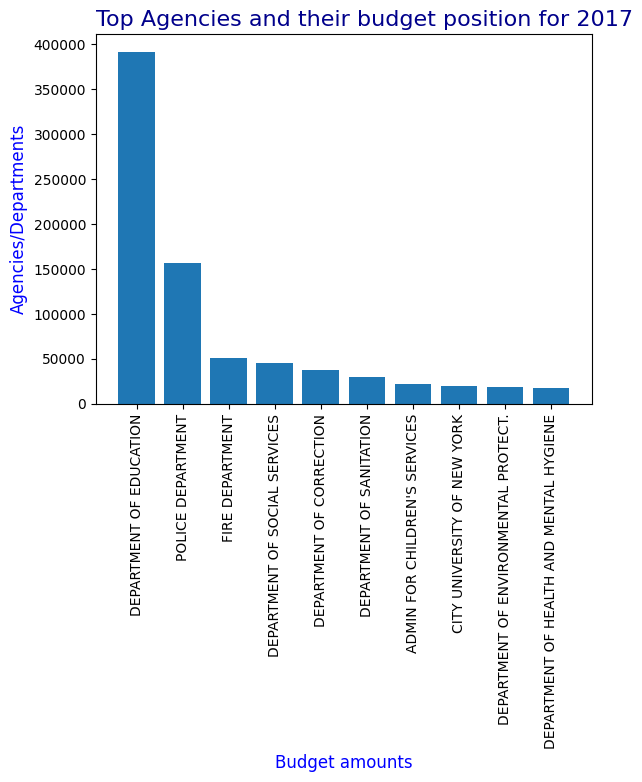

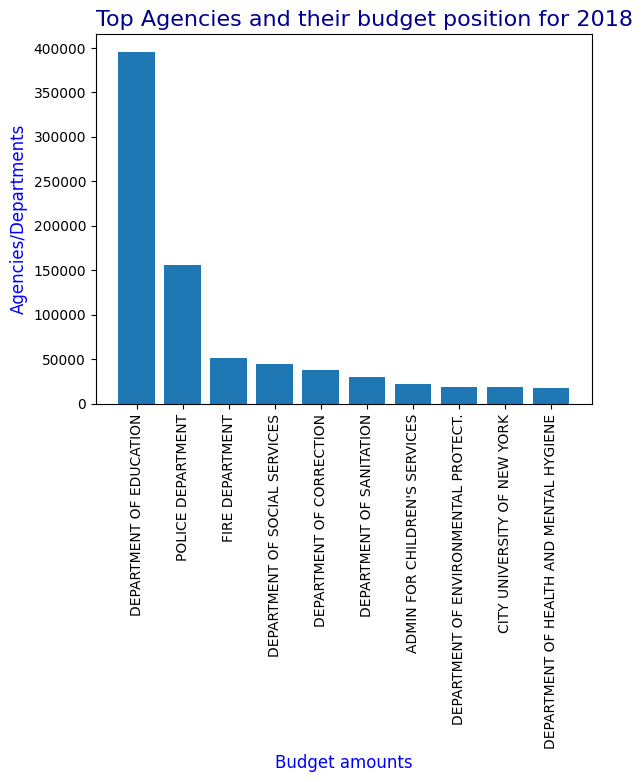

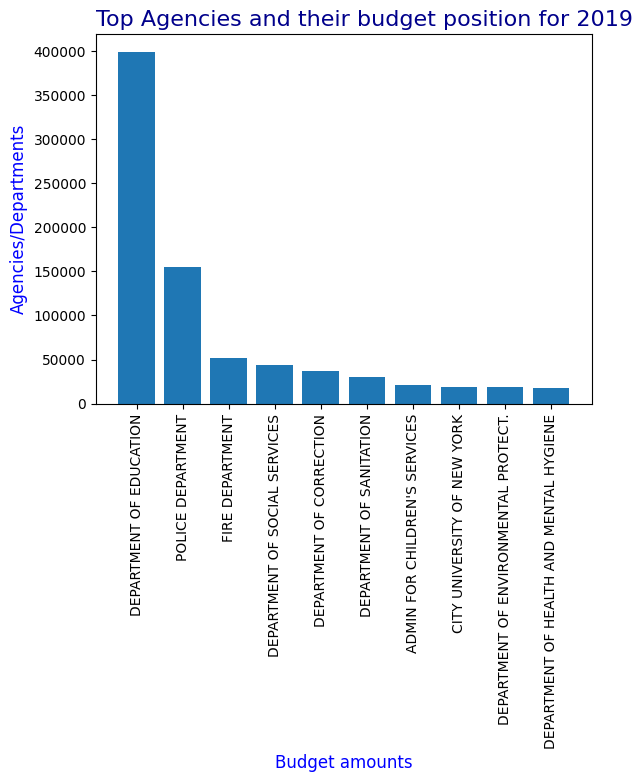

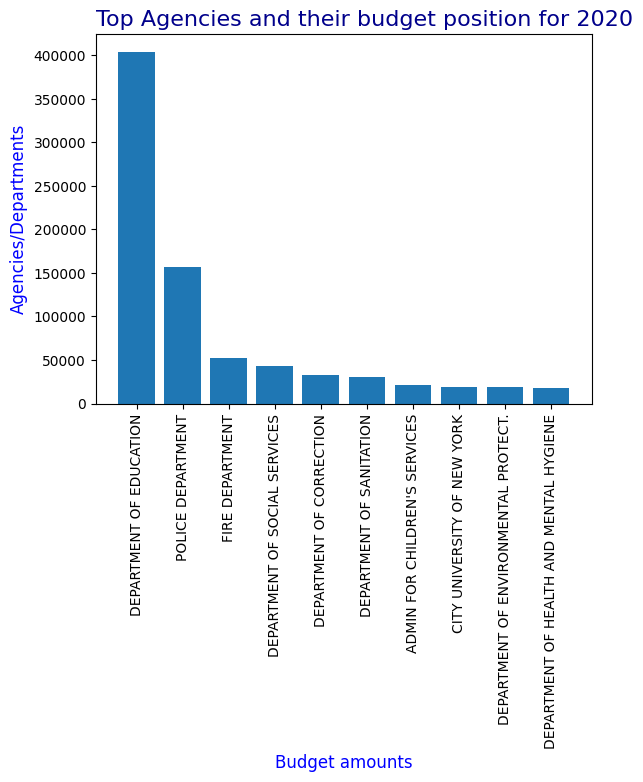

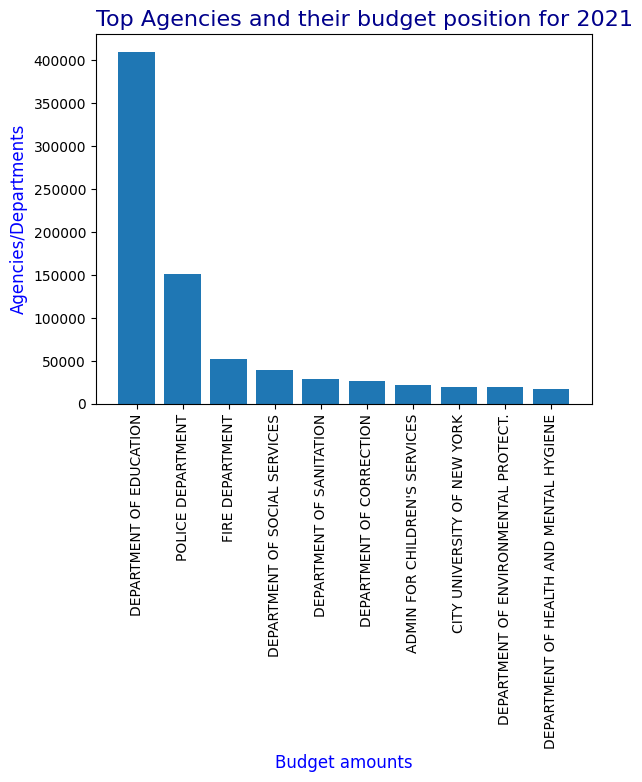

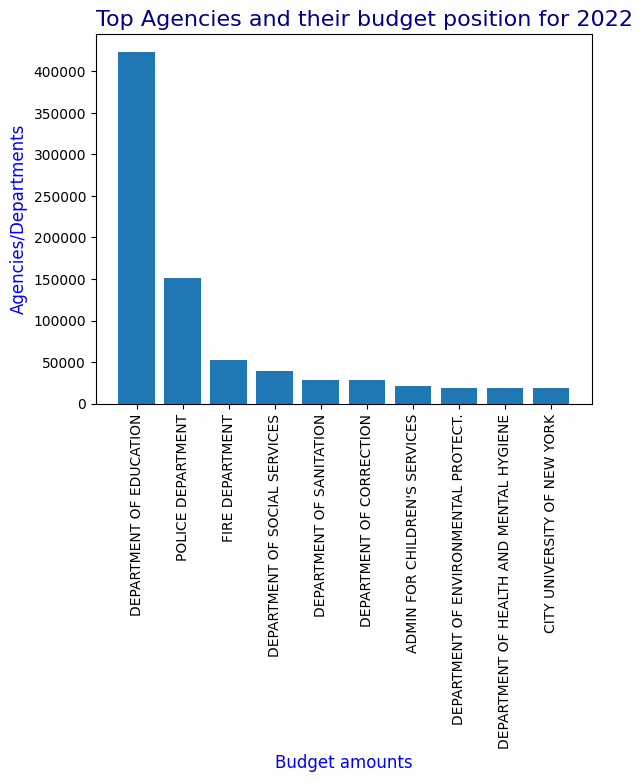

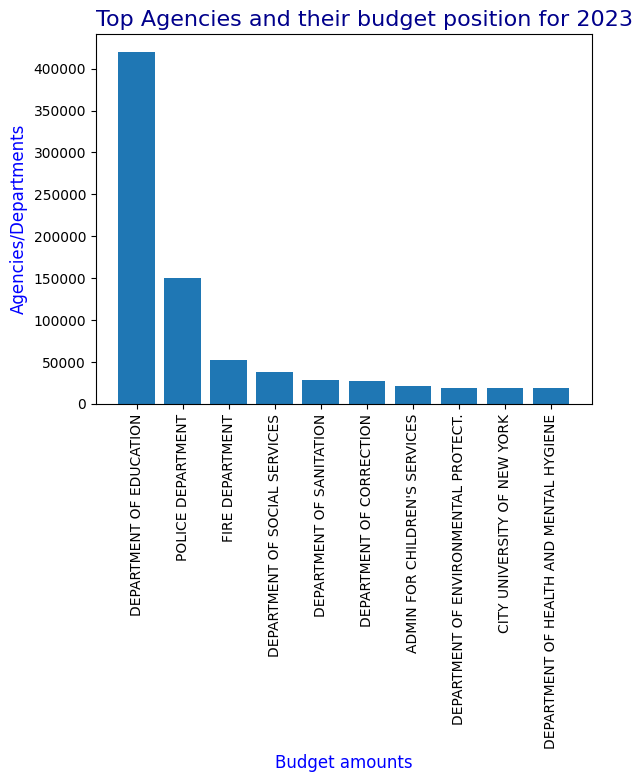

In [7]:
print(expense_budget_clean['Agency Name'].nunique())
print(sorted(expense_budget_clean['Agency Name'].unique()))



for year in sorted(expense_budget_clean['Publication Year'].unique()):
  #make a graph for each year
  expense_budget_temp = expense_budget_clean[expense_budget_clean['Publication Year'] == year]
  expense_budget_temp = expense_budget_temp.groupby(['Agency Name'])['Current Modified Budget Position'].sum().reset_index()
  expense_budget_temp = expense_budget_temp.sort_values(['Current Modified Budget Position'], ascending=[False])
  #print(expense_budget_temp)

  plt.figure()
  plt.bar(expense_budget_temp['Agency Name'].head(10), expense_budget_temp['Current Modified Budget Position'].head(10))
  title = 'Top Agencies and their budget position for ' + str(year)
  plt.title(title, loc='left', size=16, color='darkblue')
  label_font = {'color':'blue','size':12}
  plt.xlabel('Budget amounts', fontdict = label_font)
  plt.ylabel('Agencies/Departments', fontdict = label_font)
  plt.xticks(rotation=90)

plt.show()



Above, I created seven bar plots (one for each of our data's years 2017-2023). Using a for loop to go through a list of represented years, I subsetted the dataset to only that year and grouped the 'Current Modified Budget Position' by 'Agency Name'. Then, I created a bar plot for the top ten agencies/departments in that grouped dataset.  

As we can see, the graphs are not that different from one other and while some departments are in different orders, the top ten departments seems to be the same across the board with the Department of Education having a biggest part of the budget.



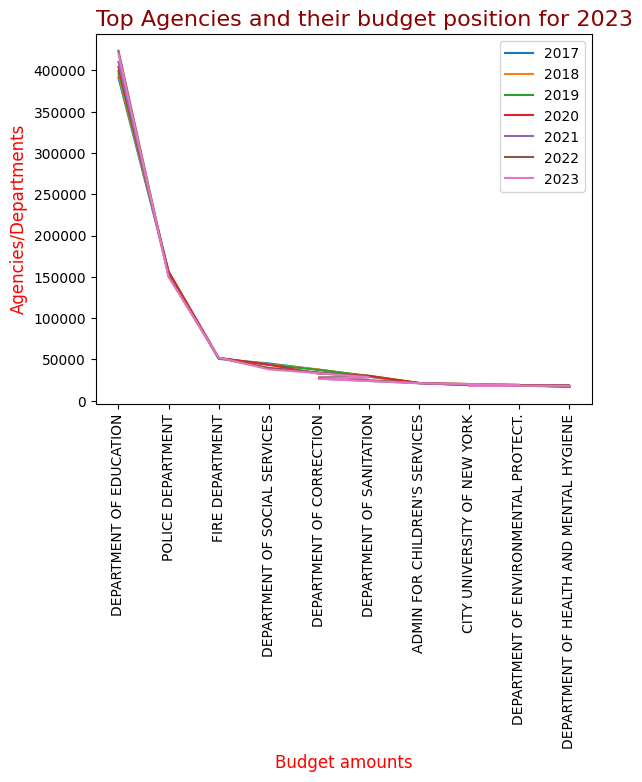

In [8]:
for year in sorted(expense_budget_clean['Publication Year'].unique()):
  #make a graph for each year
  expense_budget_temp = expense_budget_clean[expense_budget_clean['Publication Year'] == year]
  expense_budget_temp = expense_budget_temp.groupby(['Agency Name'])['Current Modified Budget Position'].sum().reset_index()
  expense_budget_temp = expense_budget_temp.sort_values(['Current Modified Budget Position'], ascending=[False])
  #print(expense_budget_temp)

  plt.plot(expense_budget_temp['Agency Name'].head(10), expense_budget_temp['Current Modified Budget Position'].head(10))
  title = 'Top Agencies and their budget position for ' + str(year)
  plt.title(title, loc='left', size=16, color='darkred')
  label_font = {'color':'red','size':12}
  plt.xlabel('Budget amounts', fontdict = label_font)
  plt.ylabel('Agencies/Departments', fontdict = label_font)
  plt.xticks(rotation=90)

plt.legend(sorted(expense_budget_clean['Publication Year'].unique()))
plt.show()

Using the same concept as the bar plots, I created a line graph above that shows the top 10 departments and the budgets from each year as different colors. The graph is hard to read because the lines are seems to overlap alot indicting that the budget amount of these departments do not change that much through the years 2017-2023.

Now, I would like to look into a couple specific departments that I feel would have been affected by certain events in the last few years to answer my research question (How has different political and economical events affect NYC Government's budget? How has the budget allocations change over the years?). The departments and the respective events affecting them that I want to investigate are:
- Department of Education with the pandemic effect (given the switch to online schooling and the aftermath of kids' education levels lowering after we returned to 'normal')  
- Police Department: with the increase in police brutality & protesting as well as the increase in hate crimes following the pandemic.
- Department of Social Services: with the early 'Recession' includes the record-high inflation rate and unemployment rate we are currently seeing

In the following graphs, the departments', listed above, budgets through the years is plotted for analyization. To create these graphs, I subsetted the dataset to just that department's 'Agency Name' and used group by to show the sum of budgets for each third of each year. Then, grouped it again only on year for the graphs.

    Publication Year  Third  Current Modified Budget Position
0               2017      1                            130466
1               2017      2                            130503
2               2017      3                            130533
3               2018      1                            131842
4               2018      2                            131872
5               2018      3                            131884
6               2019      1                            133161
7               2019      2                            133034
8               2019      3                            133073
9               2020      1                            134609
10              2020      2                            134728
11              2020      3                            134728
12              2021      1                            136758
13              2021      2                            136761
14              2021      3                            136837
15      

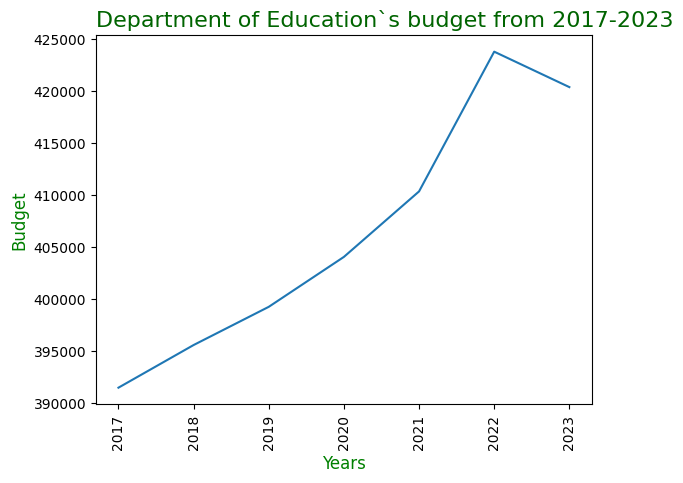

In [9]:
#Department of Education
#line/plot of just the department of education budget over the years/thirds

#subset to only ['Agency Name'] == 'Department of Education'
department_of_education = expense_budget_clean[expense_budget_clean['Agency Name'] == 'DEPARTMENT OF EDUCATION']
#group by year, third
department_of_education = department_of_education.groupby(['Publication Year','Third'])['Current Modified Budget Position'].sum().reset_index()
print(department_of_education)
department_of_education = department_of_education.groupby(['Publication Year'])['Current Modified Budget Position'].sum().reset_index()
print(department_of_education)

plt.plot(department_of_education['Publication Year'], department_of_education['Current Modified Budget Position'])
plt.title('Department of Education`s budget from 2017-2023', loc='left', size=16, color='darkgreen')
label_font = {'color':'green','size':12}
plt.xlabel('Years', fontdict = label_font)
plt.ylabel('Budget', fontdict = label_font)
plt.xticks(rotation=90)
plt.show()



The graph above is for the Department of Education where I wanted to investigate on how the forced online schooling during the pandemic years affected the department's budget. We can see a big spike in the budget from 2021 - 2022 which would align with when students were starting to come back to physical school. There is a slight decrease after the 3rd third of 2022 which might signal the end or decrease in any special measurements/extra money needed when schools first reopened after the pandemic.

    Publication Year  Third  Current Modified Budget Position
0               2017      1                             51881
1               2017      2                             52071
2               2017      3                             52071
3               2018      1                             51979
4               2018      2                             51996
5               2018      3                             52090
6               2019      1                             51671
7               2019      2                             51827
8               2019      3                             51729
9               2020      1                             52241
10              2020      2                             52241
11              2020      3                             52086
12              2021      1                             50247
13              2021      2                             50184
14              2021      3                             50322
15      

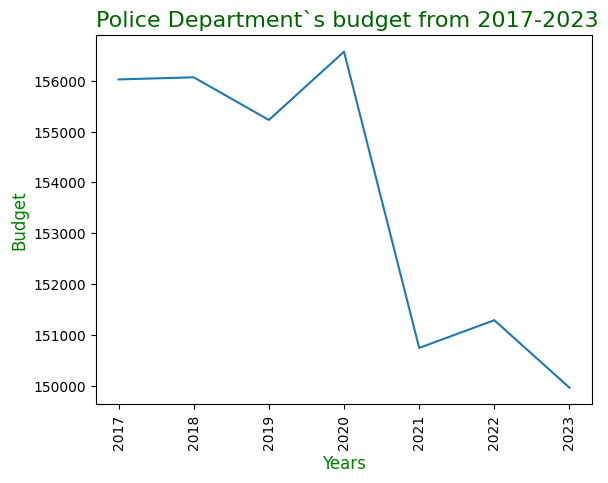

In [10]:
#Police Department
#line/plot of just the police department budget over the years/thirds

#subset to only ['Agency Name'] == 'Department Police'
police_department = expense_budget_clean[expense_budget_clean['Agency Name'] == 'POLICE DEPARTMENT']
#group by year, third
police_department = police_department.groupby(['Publication Year','Third'])['Current Modified Budget Position'].sum().reset_index()
print(police_department)
police_department = police_department.groupby(['Publication Year'])['Current Modified Budget Position'].sum().reset_index()
print(police_department)

plt.plot(police_department['Publication Year'], police_department['Current Modified Budget Position'])
plt.title('Police Department`s budget from 2017-2023', loc='left', size=16, color='darkgreen')
label_font = {'color':'green','size':12}
plt.xlabel('Years', fontdict = label_font)
plt.ylabel('Budget', fontdict = label_font)
plt.xticks(rotation=90)
plt.show()

The graph above shows the Police Department's budget over 2017-2023. Before plotting it, I predicted that the budget would have went up with the rise of hate crime and protest (a lot of it being directed to the police) would required more resources/money to deal with.   
This predictation has some truth to it as there is a small spike in budget from 2019-2020 (1st-2nd third of 2020 being the mass BLM protests and the start of the pandemic).  
However, the increase seen then is nothing compared to the decrease we see after the 3rd third of 2020. This might be due to most people spending all of 2021 and some of 2022 at home so there was less need for the Police Department. Since the pandemic ended, there has been an increase in hate crimes and subway attacks so I would think it would increase again, but it has not.

    Publication Year  Third  Current Modified Budget Position
0               2017      1                             15009
1               2017      2                             15084
2               2017      3                             15080
3               2018      1                             14689
4               2018      2                             14713
5               2018      3                             14713
6               2019      1                             14731
7               2019      2                             14684
8               2019      3                             14305
9               2020      1                             14578
10              2020      2                             14577
11              2020      3                             14404
12              2021      1                             13504
13              2021      2                             12781
14              2021      3                             12781
15      

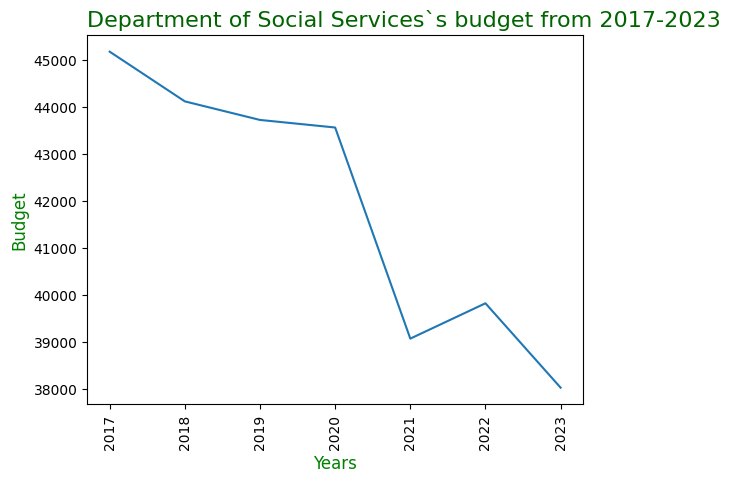

In [11]:
#Department of Social Services
#line/plot of just the department of education budget over the years/thirds

#subset to only ['Agency Name'] == 'Department Police'
department_of_social_services = expense_budget_clean[expense_budget_clean['Agency Name'] == 'DEPARTMENT OF SOCIAL SERVICES']
#group by year, third
department_of_social_services = department_of_social_services.groupby(['Publication Year','Third'])['Current Modified Budget Position'].sum().reset_index()
print(department_of_social_services)
department_of_social_services = department_of_social_services.groupby(['Publication Year'])['Current Modified Budget Position'].sum().reset_index()
print(department_of_social_services)

plt.plot(department_of_social_services['Publication Year'], department_of_social_services['Current Modified Budget Position'])
plt.title('Department of Social Services`s budget from 2017-2023', loc='left', size=16, color='darkgreen')
label_font = {'color':'green','size':12}
plt.xlabel('Years', fontdict = label_font)
plt.ylabel('Budget', fontdict = label_font)
plt.xticks(rotation=90)
plt.show()

The graph above shows the Department of Social Services's budget from 2017-2023. This was another graph that I predicted would go up as Social Services ellipses Homelessness prevention, employment/unemployment services, and temporary emergency shelters. With the early 'Recession' we find ourselves in, I expected these services to be needed more and thus the budget would increase. The graph indicates that has been going down, at different rates, since 2017. This could be seen as how high of a priority this department is for the city government or how the city government itself is being affected.

#Conclusion
With my initial research question in mind (How has different political and economical events affect NYC Government's budget? How has the budget allocations change over the years?), I have investigated the dataset mostly focusing on three different departments and the events I think could have affected them. From the plots, I would concluded that you can see the effects recent events has had on these budget records, mainly the global pandemic because it is easy to pin down the events happening for each of the three plots' major increases/decreases.

#Abstract

My goal for this project was to see if recent events had an affect on NYC Government's budget distribution to its departments. In order to investigate this, I made usage of the city government's Expense Budget report from the NYC Open Data (https://data.cityofnewyork.us/City-Government/Expense-Budget/mwzb-yiwb/about_data). This dataset is updated by the different departments three times a year with their current budget amounts. It has been being used for these records since 2016.  
My next steps were to clean the data and add a couple new columns (for thirds, year) to help guide the timeline of their records when I did my analyzation.   
During the analyzation, I realized there was 148 unique departments who have records in this dataset so I focused my attention on the top ten highest budgets to see where the highest priorities lay. Once these high priority departments were found, I choose the three I felt would have been the most visually affected by recent events to answer my research question. With a focus on the effects of the global pandemic as my main event, the three departments were the Department of Education, the Police Department, and the Department of Social Services. After looking at grouped by years datasets and plots for each department, you can see the increases and decreases of their representative budgets at times that would align with the events going on in NYC at the time. This is I was able to conclude that you can see how the city government's priorities and budget distribution changes as different departments are more or less needed/more or less of a priority as they were in the past.